F1: 0.9743181818181819 (micro), 0.9750576649746047 (macro), 0.9751510056992275 (weighted)


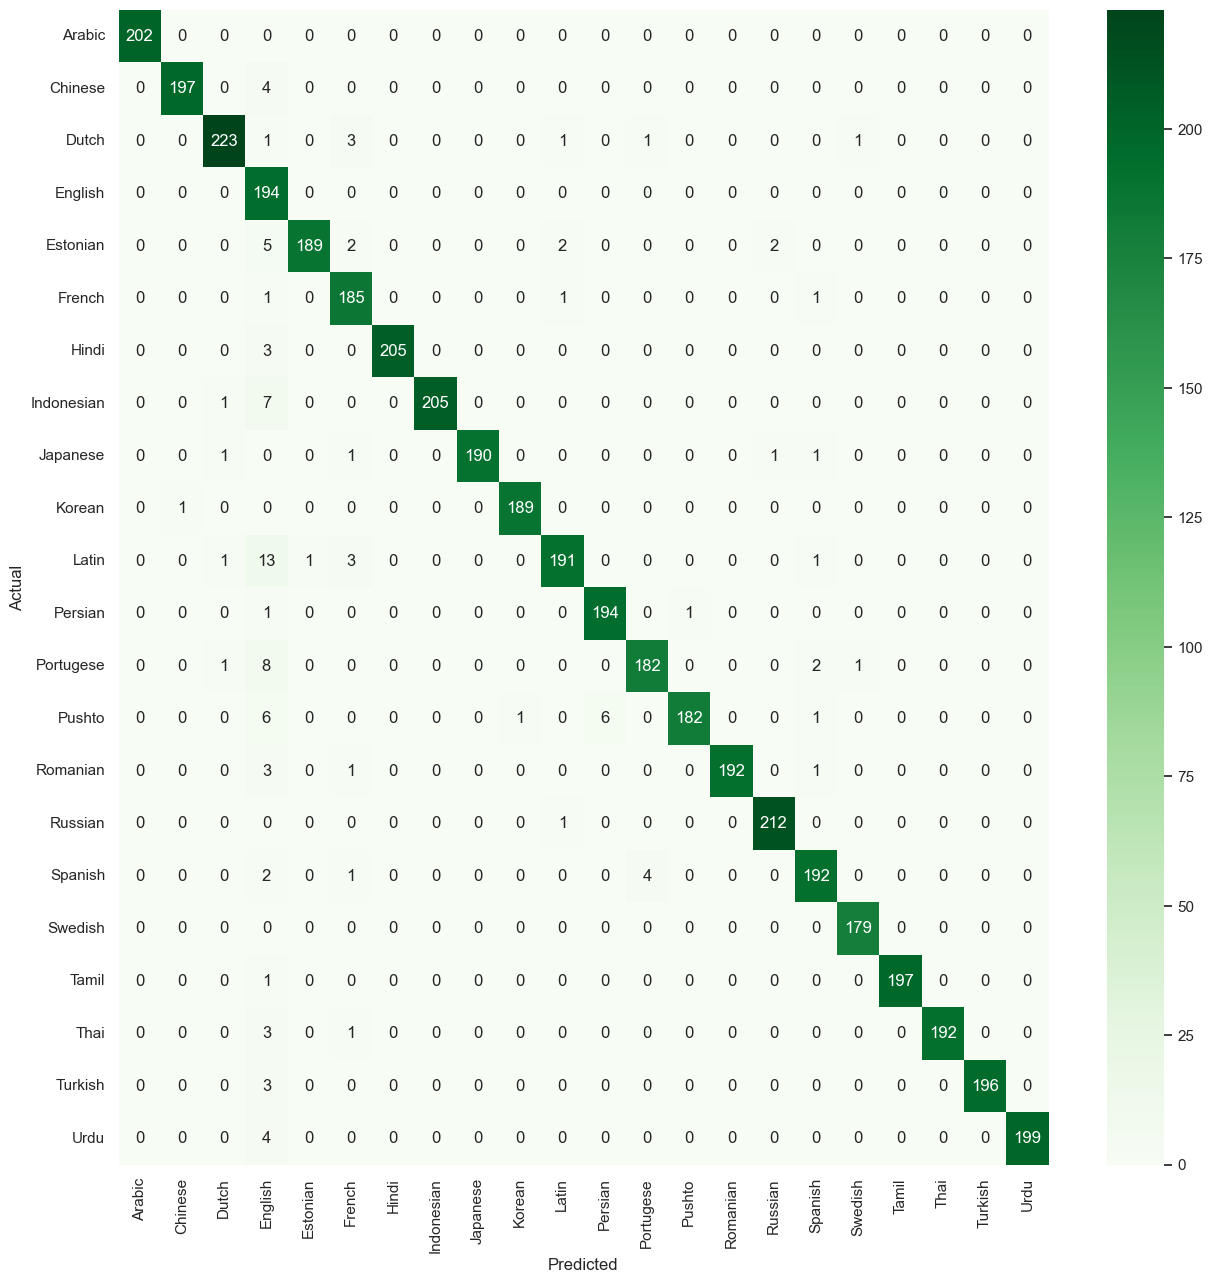

In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import normalize
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sn
import matplotlib.pyplot as plt
import scipy
import re
from collections import Counter
from asyncio.windows_events import NULL

# Load dataset
raw = pd.read_csv(r"C:\Users\ponnappa\Downloads\archive (1)\dataset.csv")

# Split dataset
X = raw['Text']
y = raw['language']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Extract Unigrams
unigramVectorizer = CountVectorizer(analyzer='char', ngram_range=(1,1))
X_unigram_train_raw = unigramVectorizer.fit_transform(X_train)
X_unigram_test_raw = unigramVectorizer.transform(X_test)
unigramFeatures = unigramVectorizer.get_feature_names_out()

def train_lang_dict(X_raw_counts, y_train):
    lang_dict = {}
    for i in range(len(y_train)):
        lang = y_train[i]
        v = np.array(X_raw_counts[i])
        if not lang in lang_dict:
            lang_dict[lang] = v
        else:
            lang_dict[lang] += v
    for lang in lang_dict:
        v = lang_dict[lang]
        lang_dict[lang] = v / np.sum(v)
    return lang_dict

language_dict_unigram = train_lang_dict(X_unigram_train_raw.toarray(), y_train.values)

# Extract top 1% Uni- & Bi-Grams
top1PrecentMixtureVectorizer = CountVectorizer(analyzer='char', ngram_range=(1,2), min_df=1e-2)
X_top1Percent_train_raw = top1PrecentMixtureVectorizer.fit_transform(X_train)
X_top1Percent_test_raw = top1PrecentMixtureVectorizer.transform(X_test)

language_dict_top1Percent = train_lang_dict(X_top1Percent_train_raw.toarray(), y_train.values)
top1PercentFeatures = top1PrecentMixtureVectorizer.get_feature_names_out()
# Define the languages variable here
# Get the unique languages from the language dictionary
languages = list(language_dict_top1Percent.keys()) 
clf=MultinomialNB()
def getRelevantGramsPerLanguage(features, language_dict, top=50):
    relevantGramsPerLanguage = {}
    for lang in languages:
        chars = []
        relevantGramsPerLanguage[lang] = chars
        v = language_dict[lang]
        sortIndex = (-v).argsort()[:top]
        for i in range(len(sortIndex)):
            chars.append(features[sortIndex[i]])
    return relevantGramsPerLanguage

top50PerLanguage_dict = getRelevantGramsPerLanguage(top1PercentFeatures, language_dict_top1Percent)
allTop50 = []
for lang in top50PerLanguage_dict:
    allTop50 += set(top50PerLanguage_dict[lang])
top50 = list(set(allTop50))

def getRelevantColumnIndices(allFeatures, selectedFeatures):
    relevantColumns = []
    for feature in selectedFeatures:
        relevantColumns = np.append(relevantColumns, np.where(allFeatures==feature))
    return relevantColumns.astype(int)

relevantColumnIndices = getRelevantColumnIndices(np.array(top1PercentFeatures), top50)
X_top50_train_raw = np.array(X_top1Percent_train_raw.toarray()[:,relevantColumnIndices])
X_top50_test_raw = X_top1Percent_test_raw.toarray()[:,relevantColumnIndices]

def toNumpyArray(data):
    data_type = type(data)
    if data_type == np.ndarray:
        return data
    elif data_type == list:
        return np.array(data)
    elif data_type == scipy.sparse.csr.csr_matrix:
        return data.toarray()
    return None

def normalizeData(train, test):
    train_result = normalize(train, norm='l2', axis=1, copy=True, return_norm=False)
    test_result = normalize(test, norm='l2', axis=1, copy=True, return_norm=False)
    return train_result, test_result

def applyNaiveBayes(X_train, y_train, X_test):
    trainArray = toNumpyArray(X_train)
    testArray = toNumpyArray(X_test)
    clf.fit(trainArray, y_train)
    y_predict = clf.predict(testArray)
    return y_predict

def plot_F_Scores(y_test, y_predict):
    f1_micro = f1_score(y_test, y_predict, average='micro')
    f1_macro = f1_score(y_test, y_predict, average='macro')
    f1_weighted = f1_score(y_test, y_predict, average='weighted')
    print("F1: {} (micro), {} (macro), {} (weighted)".format(f1_micro, f1_macro, f1_weighted))

def plot_Confusion_Matrix(y_test, y_predict, color="Blues"):
    allLabels = list(set(list(y_test) + list(y_predict)))
    allLabels.sort()
    confusionMatrix = confusion_matrix(y_test, y_predict, labels=allLabels)
    unqiueLabel = np.unique(allLabels)
    df_cm = pd.DataFrame(confusionMatrix, columns=unqiueLabel, index=unqiueLabel)
    df_cm.index.name = 'Actual'
    df_cm.columns.name = 'Predicted'
    sn.set(font_scale=0.8) # for label size
    sn.set(rc={'figure.figsize':(15, 15)})
    sn.heatmap(df_cm, cmap=color, annot=True, annot_kws={"size": 12}, fmt='g')# font size
    plt.show()

X_top50_train, X_top50_test = normalizeData(X_top50_train_raw, X_top50_test_raw)
y_predict_nb_top50 = applyNaiveBayes(X_top50_train, y_train, X_top50_test)
plot_F_Scores(y_test, y_predict_nb_top50)
plot_Confusion_Matrix(y_test, y_predict_nb_top50, "Greens")

# Function to predict language of each word in the input text
def predict_language_percentages(text):
    # Tokenize the input text into words
    words = re.findall(r'\b\w+\b', text)

    # Transform and normalize the input words
    words_transformed = top1PrecentMixtureVectorizer.transform(words)
    words_relevant = words_transformed[:, relevantColumnIndices]
    words_normalized = normalize(words_relevant, norm='l2', axis=1, copy=True, return_norm=False)

    # Predict language for each word
    predicted_languages = clf.predict(words_normalized)

    # Calculate the percentage of words for each language
    language_counts = Counter(predicted_languages)
    total_words = len(words)
    language_percentages = {lang: round((count / total_words) * 100,3) for lang, count in language_counts.items()}

    return language_percentages
# Function to predict language from user input
def predict_language(text):
    # Transform and normalize the input text
    text_transformed = top1PrecentMixtureVectorizer.transform([text])
    text_relevant = text_transformed[:, relevantColumnIndices]
    text_normalized = normalize(text_relevant, norm='l2', axis=1, copy=True, return_norm=False)
    # Predict language
    predicted_language = clf.predict(text_normalized)
    return predicted_language[0]

In [17]:
# Get user input and predict the language percentages
while(True) :
    user_input = input("Enter text to predict language percentages: ")
    if user_input!=NULL :
        predicted_lang_percentages = predict_language_percentages(user_input)
        print(f"The predicted language percentages are: {predicted_lang_percentages}")
        predicted_lang = predict_language(user_input)
        print(f"The most probable language is : {predicted_lang}")

The predicted language percentages are: {'Turkish': 8.696, 'Portugese': 26.087, 'Estonian': 13.043, 'Spanish': 4.348, 'Dutch': 21.739, 'English': 4.348, 'French': 4.348, 'Latin': 17.391}
The most probable language is : Spanish


ValueError: Found array with 0 sample(s) (shape=(0, 564)) while a minimum of 1 is required by the normalize function.